In [1]:
import sys
#Path to Trane for imports
sys.path.append('/Users/Alexander/Documents/Trane/Trane__HDI_REPO')
path_to_datasets = '../../Trane__Local_Misc/Formatted Datasets/Saudi Full Data - King Fahd Hospital/'
import pandas as pd
import trane
import json
import random
import datetime
import pickle
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
import scikitplot as skplt
from dateutil import parser

def save_obj(obj, name):
    with open('pickled_objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open('pickled_objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def generate_probs_and_nl(entity_id_column,
                            label_generating_column,
                            time_column,
                            table_meta,
                            filter_column,
                            is_pick_random_problems = True):
    generator = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    probs = []

    all_probs = list(generator.generate())

    if is_pick_random_problems:
        random.shuffle(all_probs)

    for idx, prob in enumerate(all_probs):
        probs.append(prob)
        if idx + 1 == NUM_PROBLEMS_TO_GENERATE:
            break
    prediction_problems_json = trane.prediction_problems_to_json_file(
        probs, table_meta, entity_id_column, label_generating_column, time_column, "prediction_problems.json")

    nl_descrips = trane.generate_nl_description(
        probs, table_meta, entity_id_column, label_generating_column, time_column, trane.ConstantIntegerCutoffTimes(0))
    return probs, nl_descrips
def convert(str, format = None):
    return datetime.datetime.strptime(str, format)
def file_to_table_meta(filepath):
    return trane.TableMeta(json.loads(open(filepath).read()))

In [2]:
#ER Data
er_data_df = pd.read_csv(path_to_datasets + 'ER.csv')
# er_data_meta = file_to_table_meta(path_to_datasets + 'ER_table_meta.json')

#INP Data
inpatient_data_df = pd.read_csv(path_to_datasets + 'Inpatient.csv')
inpatient_table_meta = file_to_table_meta(path_to_datasets + 'Inpatient_meta.json')

# #ODP Data
opd_data_df = pd.read_csv(path_to_datasets + 'OPD.csv')
# odp_data_meta = file_to_table_meta(path_to_datasets + 'ODP_table_meta.json')

#ODP No Diagnosis Data
#Note: does not contain headers
# opd_data_df = pd.read_csv(path_to_datasets + 'opd_without_diag.csv')

In [3]:
def num_unique_and_num_total(df, column = 'PATIENT_ID'):
    return len(set(df[column])), len(df)

In [4]:
dfs = [er_data_df, inpatient_data_df, opd_data_df]
for df in dfs:
    num_unique, num_total = num_unique_and_num_total(df.drop_duplicates())
    print("Number of entries in original data: {}, Number of unqiue id's: {}, number of id's: {}".format(len(df), num_unique, num_total))

Number of entries in original data: 3475, Number of unqiue id's: 3109, number of id's: 3475
Number of entries in original data: 64999, Number of unqiue id's: 19357, number of id's: 46077
Number of entries in original data: 1257, Number of unqiue id's: 1008, number of id's: 1257


In [5]:
ENTITY_ID_COLUMN = 'HOSP_CODE'
TIME_COLUMN = 'ADMIT_DATE'
LABEL_GENERATING_COLUMN = 'DURATION'
FILTER_COLUMN = 'PATIENT_ID'

In [6]:
inpatient_data_df[TIME_COLUMN] = inpatient_data_df[TIME_COLUMN].apply(
    parser.parse)


In [7]:
NUM_PROBLEMS_TO_GENERATE = 100
probs, nl_descrips = generate_probs_and_nl(ENTITY_ID_COLUMN, LABEL_GENERATING_COLUMN,
                     TIME_COLUMN, inpatient_table_meta, FILTER_COLUMN)

In [9]:
saudi_prediction_problems_filename = "../JSON Files/saudi_hosptial_prediction_problems.json"
trane.prediction_problems_to_json_file(probs, inpatient_table_meta, 
                                       ENTITY_ID_COLUMN, LABEL_GENERATING_COLUMN, 
                                       TIME_COLUMN, 
                                       saudi_prediction_problems_filename)

labeler = trane.Labeler()
entity_to_data_dict = trane.df_group_by_entity_id(inpatient_data_df, ENTITY_ID_COLUMN)
cutoff_time = datetime.date(2016, 1, 1)
#Note:
# The first date is: '1/1/14 0:05'
# The last date is: '9/9/16 8:21'
entity_to_data_and_cutoff_dict = trane.ConstantDatetimeCutoffTime(cutoff_time).generate_cutoffs(entity_to_data_dict)
labels = labeler.execute(entity_to_data_and_cutoff_dict, saudi_prediction_problems_filename)

In [38]:
patient_ids = set(inpatient_data_df['PATIENT_ID'])
patients_df = pd.DataFrame(list(patient_ids), columns = ['PATIENT_ID'])

inpatient_data_df['UNIQUE_ID'] = inpatient_data_df.index

hospital_codes = set(inpatient_data_df['HOSP_CODE'])
hospital_codes_df = pd.DataFrame(list(hospital_codes), columns = ['HOSP_CODE'])

In [40]:

entities = {
#     "patients": (patients_df, "PATIENT_ID"),
    "hospital_visits": (inpatient_data_df, "UNIQUE_ID"),
    "hospital_codes": (hospital_codes_df, "HOSP_CODE")
}
relationships = [
    ("hospital_codes", "HOSP_CODE", "hospital_visits", "HOSP_CODE"),
]
cutoff_times = [[_, cutoff_time] for _ in hospital_codes]
cutoff_times = pd.DataFrame(cutoff_times, columns = ['HOSP_CODE', 'cutoff_time'])

feature_matrix, feature_definitions = ft.dfs(entities = entities,
    relationships = relationships,
    target_entity = "hospital_codes",
    cutoff_time = cutoff_times)
feature_matrix, features = ft.encode_features(feature_matrix, feature_definitions)


Beginning on index: 0
Classifier Accuracy: 0.9986
Baseline Accuracy Metric: 0.9986, based on using training_labels as the prediction


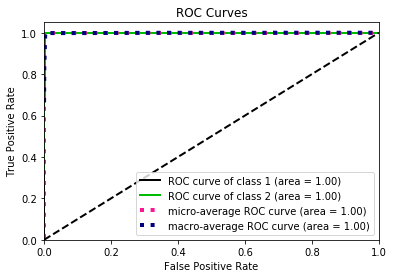

Beginning on index: 1
Classifier Accuracy: 0.8150
Baseline Accuracy Metric: 0.8150, based on using training_labels as the prediction


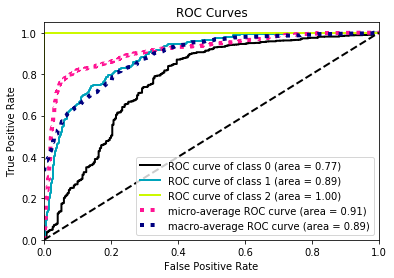

Beginning on index: 2
Classifier Accuracy: 0.1843
Baseline Accuracy Metric: 0.1843, based on using training_labels as the prediction
Beginning on index: 3
Beginning on index: 4
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


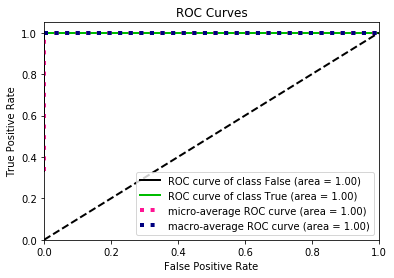

Beginning on index: 5
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


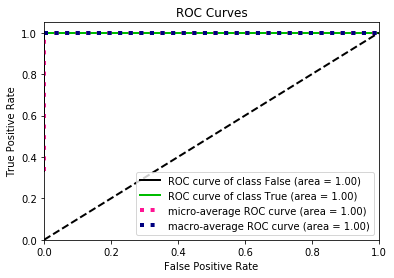

Beginning on index: 6
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


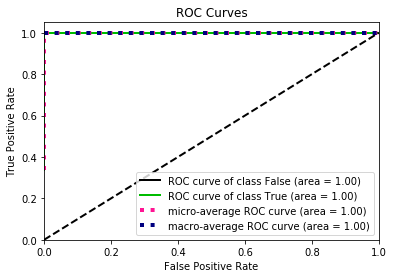

Beginning on index: 7
Beginning on index: 8
Beginning on index: 9
Beginning on index: 10
Beginning on index: 11
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


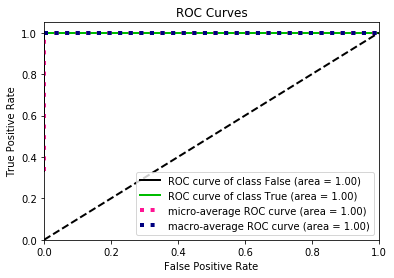

Beginning on index: 12
Beginning on index: 13
Beginning on index: 14
Beginning on index: 15
Beginning on index: 16
Beginning on index: 17
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


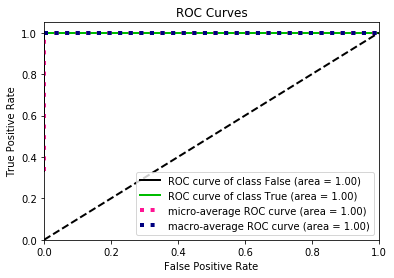

Beginning on index: 18
Beginning on index: 19
Classifier Accuracy: 0.8737
Baseline Accuracy Metric: 0.8737, based on using training_labels as the prediction


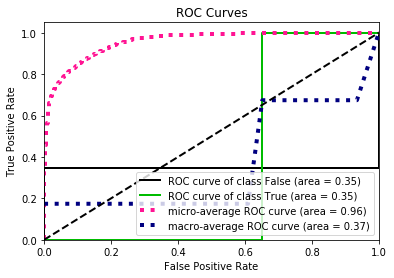

Beginning on index: 20
Classifier Accuracy: 0.8047
Baseline Accuracy Metric: 0.8047, based on using training_labels as the prediction
Beginning on index: 21
Beginning on index: 22
Beginning on index: 23
Beginning on index: 24
Beginning on index: 25
Beginning on index: 26
Beginning on index: 27
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


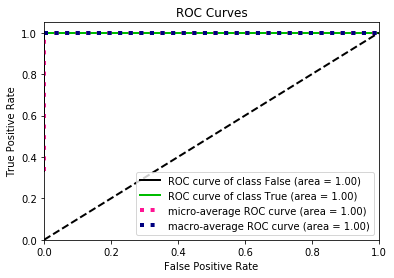

Beginning on index: 28
Beginning on index: 29
Beginning on index: 30
Classifier Accuracy: 0.8047
Baseline Accuracy Metric: 0.8047, based on using training_labels as the prediction
Beginning on index: 31
Classifier Accuracy: 0.8778
Baseline Accuracy Metric: 0.8778, based on using training_labels as the prediction
Beginning on index: 32
Beginning on index: 33
Classifier Accuracy: 0.0028
Baseline Accuracy Metric: 0.0028, based on using training_labels as the prediction
Beginning on index: 34
Classifier Accuracy: 0.7971
Baseline Accuracy Metric: 0.7971, based on using training_labels as the prediction


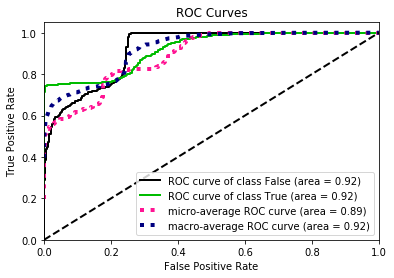

Beginning on index: 35
Classifier Accuracy: 0.9821
Baseline Accuracy Metric: 0.9821, based on using training_labels as the prediction


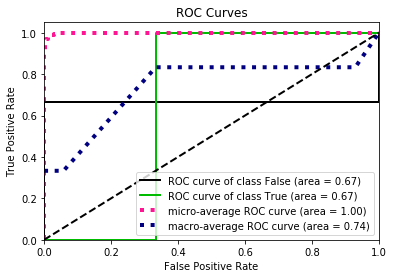

Beginning on index: 36
Classifier Accuracy: 0.5369
Baseline Accuracy Metric: 0.5369, based on using training_labels as the prediction
Beginning on index: 37
Classifier Accuracy: 0.7792
Baseline Accuracy Metric: 0.7792, based on using training_labels as the prediction


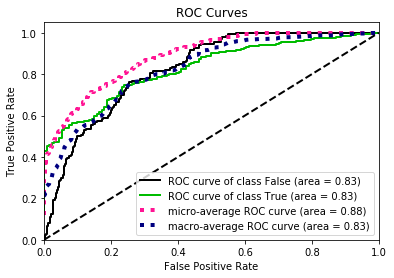

Beginning on index: 38
Classifier Accuracy: 0.2988
Baseline Accuracy Metric: 0.2988, based on using training_labels as the prediction
Beginning on index: 39
Beginning on index: 40
Beginning on index: 41
Beginning on index: 42
Beginning on index: 43
Beginning on index: 44
Classifier Accuracy: 0.8778
Baseline Accuracy Metric: 0.8778, based on using training_labels as the prediction
Beginning on index: 45
Classifier Accuracy: 0.7861
Baseline Accuracy Metric: 0.7861, based on using training_labels as the prediction


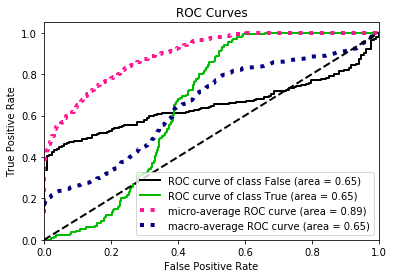

Beginning on index: 46
Classifier Accuracy: 0.6549
Baseline Accuracy Metric: 0.6549, based on using training_labels as the prediction


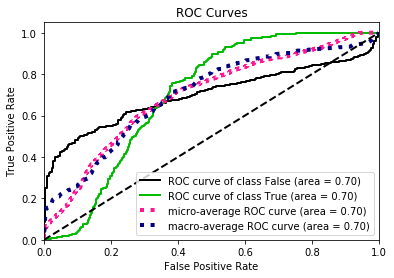

Beginning on index: 47
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


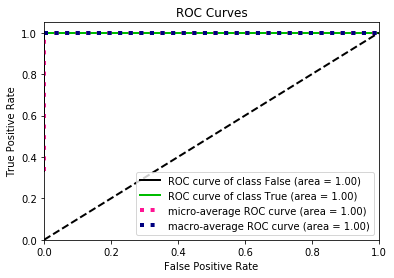

Beginning on index: 48
Beginning on index: 49
Beginning on index: 50
Classifier Accuracy: 0.0028
Baseline Accuracy Metric: 0.0028, based on using training_labels as the prediction
Beginning on index: 51
Classifier Accuracy: 0.9993
Baseline Accuracy Metric: 0.9993, based on using training_labels as the prediction


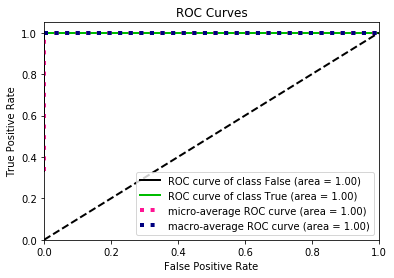

Beginning on index: 52
Classifier Accuracy: 0.0028
Baseline Accuracy Metric: 0.0028, based on using training_labels as the prediction
Beginning on index: 53
Classifier Accuracy: 0.9869
Baseline Accuracy Metric: 0.9869, based on using training_labels as the prediction


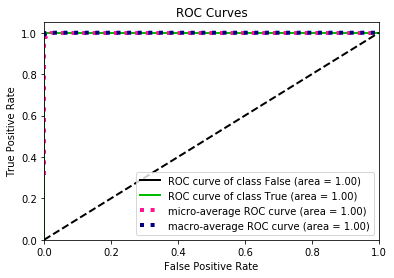

Beginning on index: 54
Classifier Accuracy: 0.9869
Baseline Accuracy Metric: 0.9869, based on using training_labels as the prediction


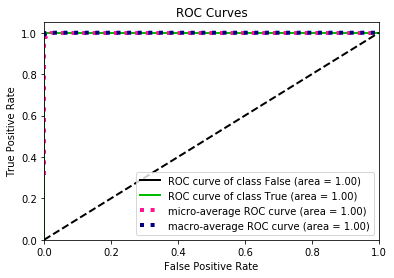

Beginning on index: 55
Classifier Accuracy: 0.8778
Baseline Accuracy Metric: 0.8778, based on using training_labels as the prediction


In [66]:
auc_scores = []
for i in range(len(labels)):
    print("Beginning on index: {}".format(i))
    label = labels[i]
    prediction_problem = probs[i]
    logistic = linear_model.LogisticRegression()

    label = label.dropna()
    hosp_code_indices = set(label['HOSP_CODE'])
    training_features = feature_matrix[feature_matrix.index.isin(hosp_code_indices)]
    training_labels = list(label['problem_label_excluding_data_post_cutoff_time'])

    true_labels = list(label['problem_label_all_data'])

    try:
        logistic.fit(training_features, training_labels)
    except:
        continue

    predicted_labels = list(logistic.predict(training_features))
    predicted_probabilities = logistic.predict_proba(training_features)

    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Classifier Accuracy: {0:.4f}".format(accuracy, prediction_problem))

    accuracy_no_prediction = accuracy_score(training_labels, predicted_labels)
    print("Baseline Accuracy Metric: {0:.4f}, based on using training_labels as the prediction".format(accuracy, prediction_problem))
    
    try:
        skplt.metrics.plot_roc_curve(true_labels, predicted_probabilities)
        plt.show()
    except:
        continue


In [61]:
len(true_labels)

1449

In [62]:
len(predicted_probabilities)

1449

In [54]:
true_labels = list(true_labels)
num_correct = 0
for i in range(1449):
    if true_labels[i] == predicted_labels[i]:
        num_correct += 1

In [55]:
num_correct

1447

In [73]:
indices = [0, 1, 4, 5, 6, 11, 17, 19, 27, 34, 35, 37, 45, 46, 47, 51, 53, 54]
for idx in indices:
    print(probs[idx])
    

AllFilterOp(PATIENT_ID)->EqRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->CountAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->IdentityRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->SumAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->EqRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->SumAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->GreaterRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->FirstAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->EqRowOp(DURATION)->IdentityTransformationOp(DURATION)->FirstAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->LessRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->SumAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->IdentityRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->LastAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->EqRowOp(DURATION)->ObjectFrequencyTransformationOp(DURATION)->FirstAggregationOp(DURATION)
AllFilterOp(PATIENT_ID)->GreaterRowOp(DURATION)->ObjectFrequencyTra